In [95]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import time
from math import pi
import matplotlib.pyplot as plt

Following the order of [Spatiotemporal Tiling of the Kuramoto-Sivashinsky Equation](#thesis), the next process that was developed after the ability to find periodic orbits was to clip out smaller domains and use them to find "fundamental periodic orbits". These are the smallest periodic orbits which serve as building blocks for all other solutions.


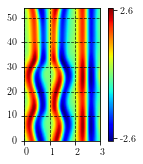

In [3]:
orbit_ = read_h5('OrbitKS_T54p129_L26p744.h5', directory='../data/examples/')
orbit_.plot()

The structure defined approximately on $t \in [0, 20], x \in [0, 2]$ looks to repeat twice. Therefore this is the target of the clipping. Again, I want to stress that this iterative manner of clipping is now known to be **unnecessary**, but it was how this calculation was originally performed. Orbithunter's utility again shines here via the function 'clip'. First, because it is somewhat hard to eyeball, I adjust the field slightly via some small rotations

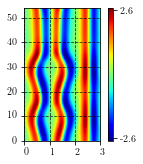

In [4]:
orbit_.rotate(0.1, axis=1).rotate(2.5, axis=0).plot()

I then clip out the subdomain, clipping automatically calculates the corresponding field, discretization, parameters.

In [5]:
?clip

In [6]:
clipped_orbit = clip(orbit_.rotate(5, axis=0).rotate(0.1, axis=1), ((0., 20), (None, None)))

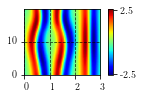

In [7]:
clipped_orbit.plot()

In [8]:
clipping_step_1_result = converge(clipped_orbit, precision='machine', method='hybrid', verbose=True)

Starting gradient descent. Initial residual=0.018326172267129365, target=1e-15, max_iter=6144
#################################################
 Residual=0.0009365859045541503 after 5000 gradient descent iterations. Current parameter values:(19.999700413746126, 26.744199797356558, 0)
###########Starting lstsq. Initial residual=0.000898512180680552, target=1e-15
1023344444444444444444433 Residual=1.2455245133061829e-05 after 25 lstsq iterations
33322100
Converged. exiting with residual 2.391765085148782e-23


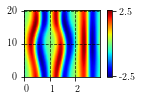

In [9]:
clipping_step_1_result.orbit.plot()

In [11]:
clipping_orbit_1 = clipping_step_1_result.orbit
clipping_orbit_1.residual()

2.391765085148782e-23

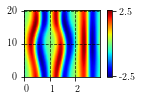

In [12]:
clipping_orbit_1.plot()

For this demonstration, I will use the very first orbit and clipping method I ever applied, which was an iterative procedure to find (converge) a sequence of progressively smaller orbits.

In [13]:
clipping_step_2_orbit = clip(clipping_step_1_result.orbit, ((None, None), (0,2)))

In [14]:
clipping_step_2_result = converge(clipping_step_2_orbit)
clipping_orbit_2 = clipping_step_2_result.orbit

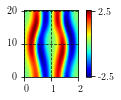

In [15]:
clipping_orbit_2.plot()

In [16]:
antisymmetric_clipping = convert_class(clipping_orbit_2, AntisymmetricOrbitKS)

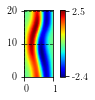

In [17]:
antisymmetric_clipping.plot()

Don't even need to run ```converge``` again because it is indeed in the antisymmetric subspace!

In [34]:
int1 = kse_integrate(OrbitKS(seed=0, parameters=(512, 512), M=1024), verbose=True, integration_time=1000, step_size=0.25)

Integration progress [#########################]

In [35]:
int1

OrbitKS({"basis": "field", "parameters": ["5.12e+02", "5.12e+02", "0.e+00"], "field_shape": ["4001", "1024"]})

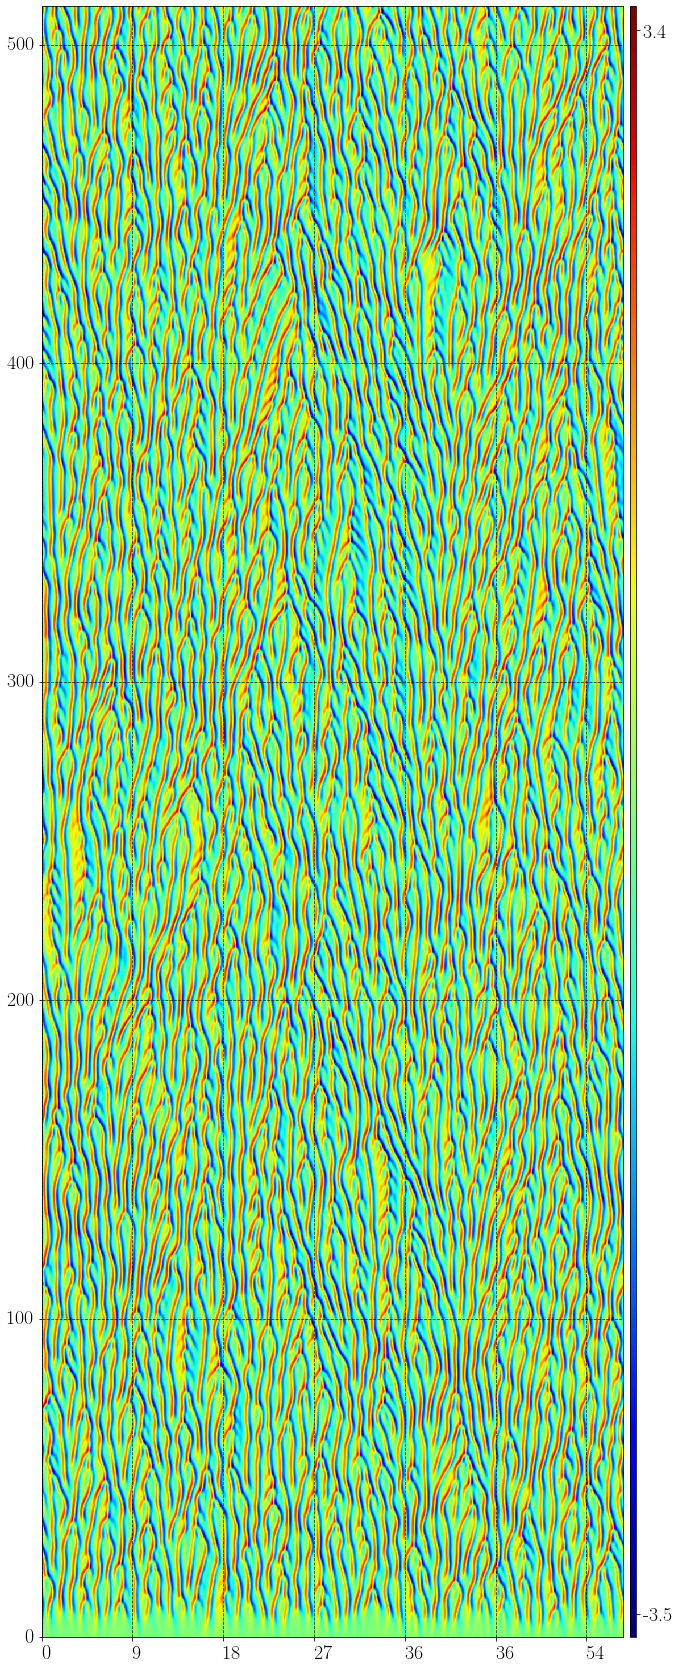

In [36]:
int1.plot(figsize=(10,30))

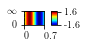

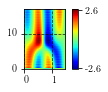

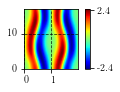

In [57]:
from orbithunter.gluing import tile_dictionary_ks
td = tile_dictionary_ks()
td[0].plot()
td[1].plot()
td[2].plot()
td = rediscretize_tiling_dictionary(td, new_shape=(128,32))

In [58]:
td[1].L / td[1].M

0.40686143374013595

In [59]:
int1.L / int1.M

0.5

In [60]:
td[1].T / td[1].N

0.1339545900982726

In [61]:
int1.T / int1.N

0.1279680079980005

In [64]:
int1.T / td[1].T

29.860865514690428

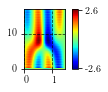

In [68]:
td[1].plot()

In [69]:
td

{0: OrbitKS({"basis": "field", "parameters": ["0.e+00", "6.391e+00", "0.e+00"], "field_shape": ["128", "32"]}),
 1: OrbitKS({"basis": "field", "parameters": ["1.715e+01", "1.302e+01", "0.e+00"], "field_shape": ["128", "32"]}),
 2: OrbitKS({"basis": "field", "parameters": ["1.715e+01", "1.759e+01", "0.e+00"], "field_shape": ["128", "32"]})}

In [88]:
np.roll(int1.state, int1.M, axis=1) - int1.state

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [120]:
int2 = rediscretize(int1, new_shape=(2048,2048))

In [129]:
merger= rediscretize(td[1], new_shape=(64,64))

In [125]:
merger

OrbitKS({"basis": "field", "parameters": ["1.715e+01", "1.302e+01", "0.e+00"], "field_shape": ["128", "32"]})

In [127]:
merger.L / merger.M

0.40686143374013595

In [121]:
int2.T / 2048

0.25

In [122]:
int2.L / 2048

0.25

In [133]:
norms = np.zeros([int2.N-merger.N, int2.M-merger.M])
intstate = int2.state
mergerstate = merger.state
for n in range(int2.N-merger.N):
    if np.mod(n, (int2.N-merger.N)//10) == 0:
        print('#', end='')
    for m in range(int2.M-merger.M):
        norms[n, m] = intstate[n:n+merger.N, m:m+merger.M].ravel().dot(mergerstate.ravel())

###########

In [98]:
import pandas as pd

In [101]:
np.where(norms < 90)

(array([   0,    0,    0, ..., 3872, 3872, 3872], dtype=int64),
 array([ 64,  65,  66, ..., 987, 988, 989], dtype=int64))

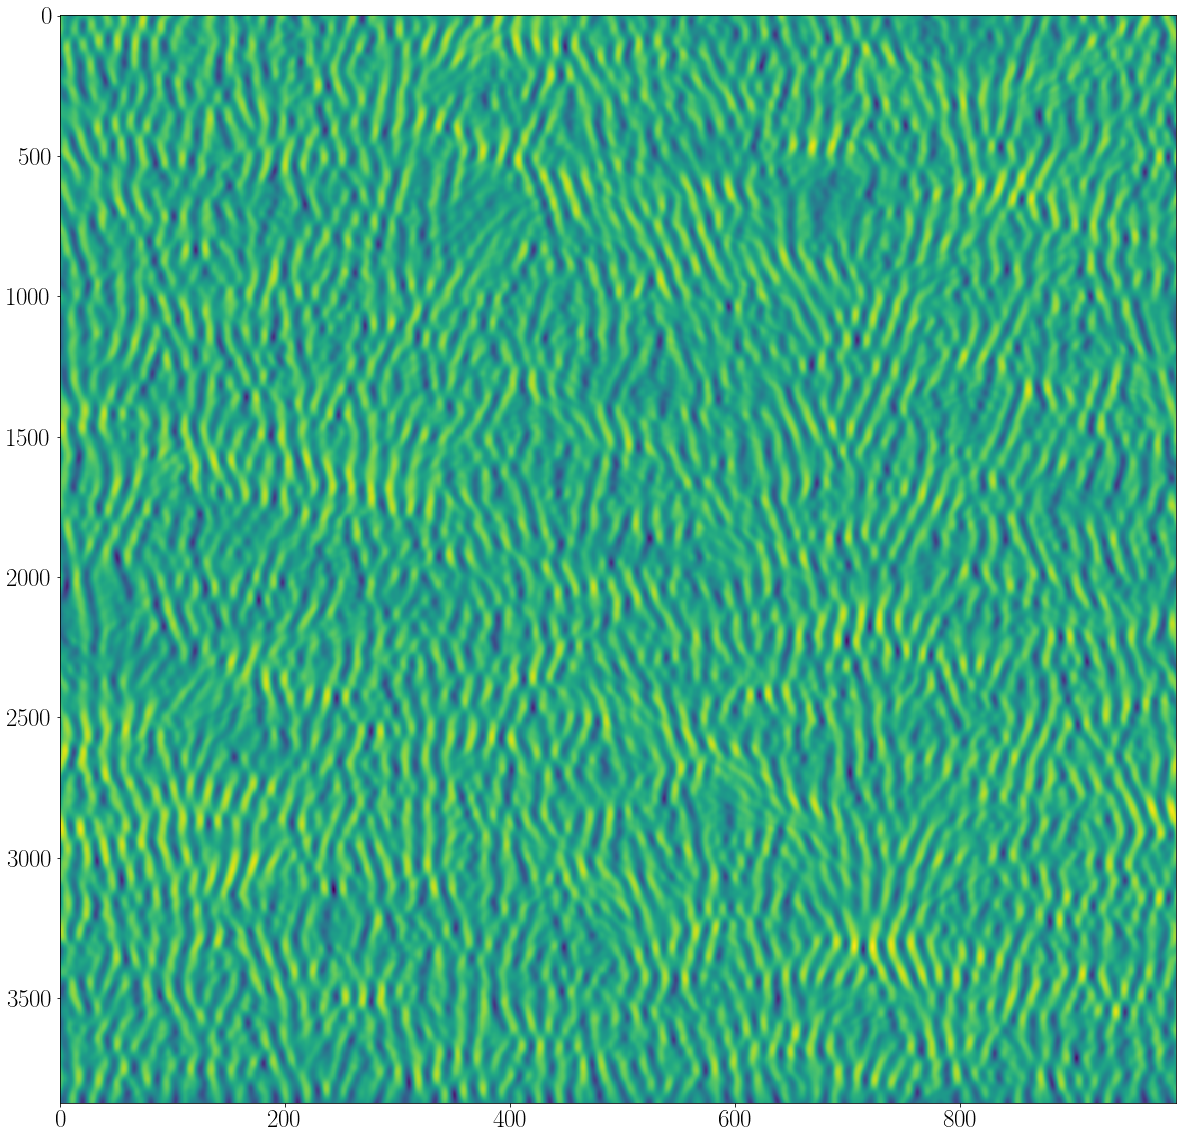

In [117]:
fig = plt.figure(figsize=(20,20))
_ = plt.imshow(norms, interpolation='none', aspect='auto')
_ = plt.show()

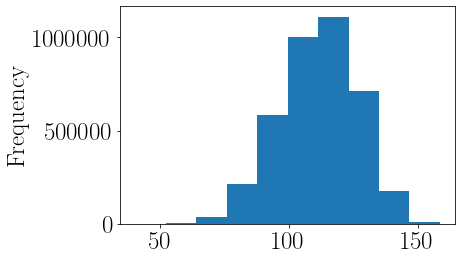

In [99]:
pd.Series(norms.ravel()).plot.hist()

In [96]:
plt.hist(norms.ravel())

(array([1.820000e+02, 5.016000e+03, 3.636200e+04, 2.106610e+05,
        5.813790e+05, 9.996800e+05, 1.111561e+06, 7.118680e+05,
        1.763640e+05, 8.943000e+03]),
 array([ 40.4980454 ,  52.27888116,  64.05971693,  75.8405527 ,
         87.62138847,  99.40222424, 111.18306001, 122.96389578,
        134.74473154, 146.52556731, 158.30640308]),
 <a list of 10 Patch objects>)

Error in callback <function flush_figures at 0x000002155AED79D8> (for post_execute):


KeyboardInterrupt: 

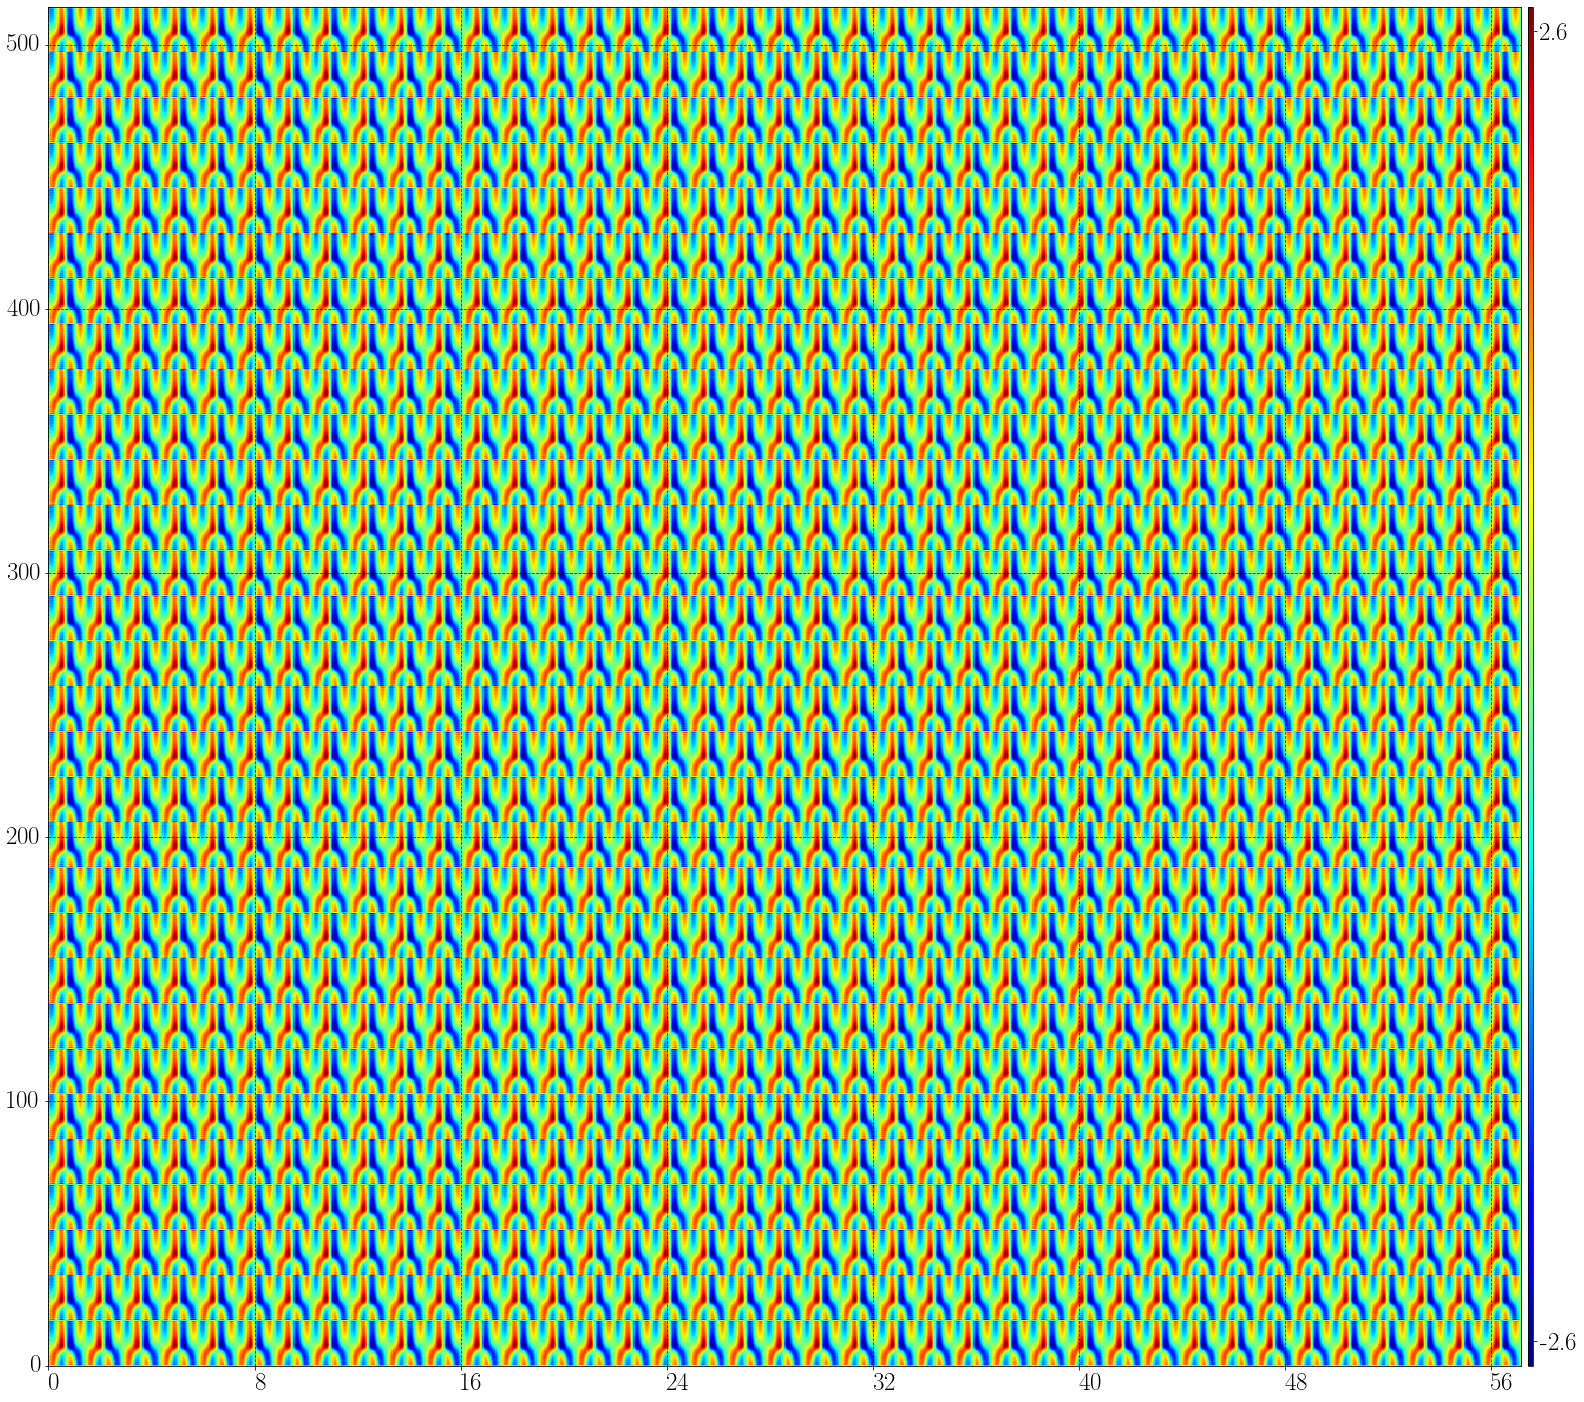

In [77]:
symbol_array = np.ones([30,39])
tiled_orbit = tile(symbol_array, td, OrbitKS, stripwise=False)
tiled_orbit.plot(figsize=(25,25))

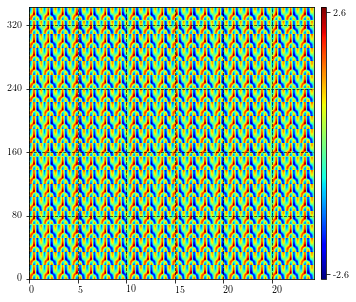

In [75]:
symbol_array = np.ones([20,20])
tiled_orbit = tile(symbol_array, td, OrbitKS, stripwise=True)
tiled_orbit.plot(figsize=(5,5))

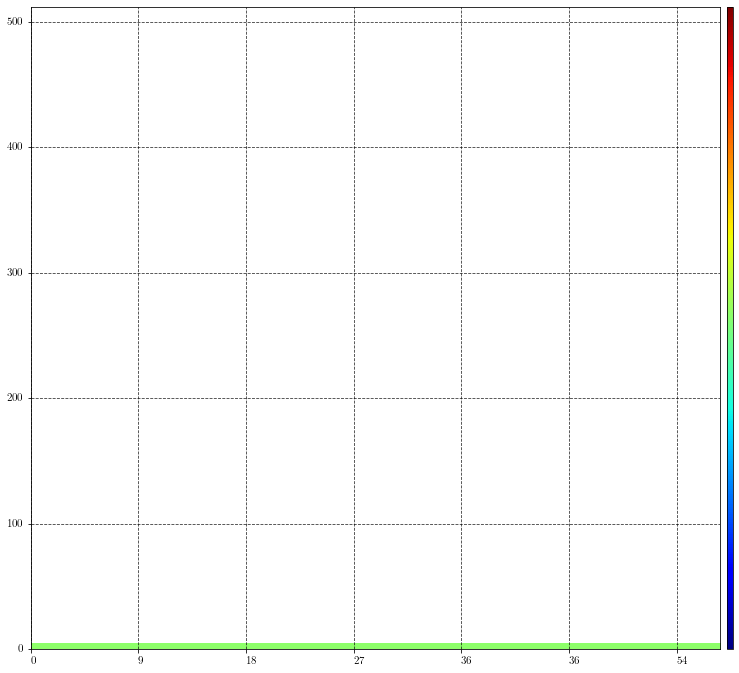

In [29]:
masked_field = mask_orbit(int1, ((380,420), (17,19)), mask_region='interior')
masked_field.plot()

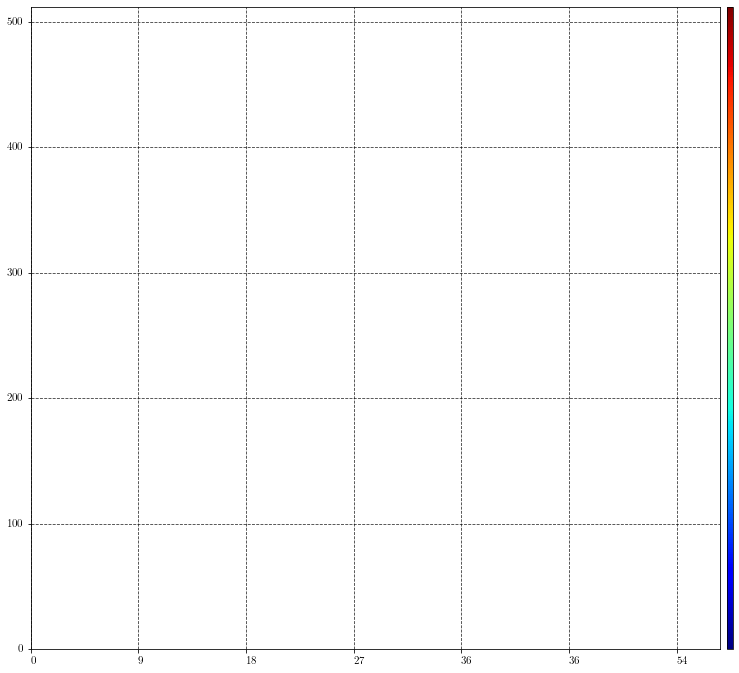

In [30]:
masked_field = mask_orbit(int1, ((380,420), (17,19)))
masked_field.plot()

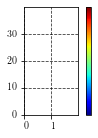

In [22]:
clipped_field = clip(int1, ((380,420), (17,19)))
clipped_field.plot()

In [23]:
clipping_result = converge(clipped_field, method='hybrid')

In [24]:
clipping_result.orbit.residual()

nan

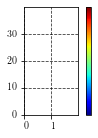

In [25]:
clipping_result.orbit.plot()

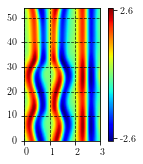

In [26]:
orbit_.plot()